<a href="https://colab.research.google.com/github/ahliminha/nlp-recruiting-test/blob/master/resolu%C3%A7%C3%A3o_prova_tecnica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prova Técnica - Resolução

**Formato**: Problema Online + Entrevista subsequente

**Prazo**: 7 dias

**Descrição**: O problema consiste em prever a nota de avaliação dos clientes de um website de ecommerce, com base nos dados de avaliações (train_df.csv).

**Entregáveis**: link para repositório no Github com ao menos os seguintes arquivos:
- README.md
- notebook da solução (`resolução_prova_tecnica.ipynb`)
- source-code (`./src`)
- requirements.txt

**Dados**: train_df.csv
- Tabela de dados de empresa de ecommerce com mais de 130 mil avaliações de clientes. A base oferece informações sobre o perfil do revisor, como sexo, idade e localização geográfica.
    - y label column: overall_rating

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
! pip install joypy
! pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation
from random import seed
import scikitplot as skplt
from imblearn.over_sampling import SMOTE

seed(0)

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nlp-recruiting-test/data/train_df.csv')

In [6]:
data.head()

,index,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,overall_rating
0,95851,2018-04-20 11:56:28,c951f3a4511b554a1f34330903c320f34cfccbdf8de357...,111586438,Depilador Elétrico Philips Satinelle HP6403/30,philips,Beleza e Perfumaria,Depilação,Depilador,Yes,Muito eficiente e prático! Depilação rápida em...,1978.0,F,ES,5
1,115536,2018-05-10 18:56:36,21da6d1c6d022a5c67da402d3082c7c438660f4252b7c3...,19399940,Hidratante Corporal Dior Addict Body Mist Femi...,NaN,Beleza e Perfumaria,Tratamento de Pele,Cheiro de rica,Yes,"Adoro o perfume que fica na pele, ele não é um...",1986.0,F,SP,5
2,1254,2018-01-02 07:02:48,eaf2f059cbb702e377bf95ac998aa4365f851937a3b419...,22747780,Controle Com Fio Para Xbox 360 Slim / Fat E Pc...,NaN,Games,Xbox 360,Bom produto,Yes,funciona o que é importante bom produto o text...,1978.0,M,ES,3
3,86792,2018-04-11 16:45:45,e5bb0709d14bc4a00aeaeb1f111616e69f57239dff7da6...,22857850,Kit Edredom + Lençol Aconchego Dupla Face Casa...,NaN,"Cama, Mesa e Banho",Edredom,Nao recebi onprofuto e nem satisfacao,No,Gostaria de saber da minha entrega ate hoje na...,1969.0,F,RJ,1
4,35543,2018-02-02 16:30:23,420a3ab1adf3c6010d491c8def04e19b1439ed01df7038...,132207708,Smartphone Motorola Moto E4 Dual Chip Android ...,motorola,Celulares e Smartphones,Smartphone,Excelente aquisição!,Yes,Entrega super rápida! Quando da compra tive c...,1965.0,M,PE,4


## Explorando os dados

In [7]:
def percentage_of_column(col: str):
  print(f"The percentage of unique {col} and all purchases is :", (data[col].nunique() / data.shape[0]) * 100, "%")

In [8]:
columns_of_interest = ["product_id", "reviewer_id", "product_brand", "site_category_lv1", "site_category_lv2"]
for col in columns_of_interest:
  percentage_of_column(col)

The percentage of unique product_id and all purchases is : 38.68250580747512 %
The percentage of unique reviewer_id and all purchases is : 87.41241572078793 %
The percentage of unique product_brand and all purchases is : 0.9301403237077187 %
The percentage of unique site_category_lv1 and all purchases is : 0.050048159549755424 %
The percentage of unique site_category_lv2 and all purchases is : 0.6629020378099681 %


### Try to lowecase them all and verify if the similarities are also the same again

In [9]:
data[columns_of_interest] = data[columns_of_interest].apply(lambda x: x.str.lower().replace('nan', None))
for col in columns_of_interest:
  percentage_of_column(col)

The percentage of unique product_id and all purchases is : 38.68250580747512 %
The percentage of unique reviewer_id and all purchases is : 87.41241572078793 %
The percentage of unique product_brand and all purchases is : 0.9301403237077187 %
The percentage of unique site_category_lv1 and all purchases is : 0.050048159549755424 %
The percentage of unique site_category_lv2 and all purchases is : 0.6600691231184724 %


In [10]:
data.head()

,index,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,overall_rating
0,95851,2018-04-20 11:56:28,c951f3a4511b554a1f34330903c320f34cfccbdf8de357...,111586438,Depilador Elétrico Philips Satinelle HP6403/30,philips,beleza e perfumaria,depilação,Depilador,Yes,Muito eficiente e prático! Depilação rápida em...,1978.0,F,ES,5
1,115536,2018-05-10 18:56:36,21da6d1c6d022a5c67da402d3082c7c438660f4252b7c3...,19399940,Hidratante Corporal Dior Addict Body Mist Femi...,NaN,beleza e perfumaria,tratamento de pele,Cheiro de rica,Yes,"Adoro o perfume que fica na pele, ele não é um...",1986.0,F,SP,5
2,1254,2018-01-02 07:02:48,eaf2f059cbb702e377bf95ac998aa4365f851937a3b419...,22747780,Controle Com Fio Para Xbox 360 Slim / Fat E Pc...,NaN,games,xbox 360,Bom produto,Yes,funciona o que é importante bom produto o text...,1978.0,M,ES,3
3,86792,2018-04-11 16:45:45,e5bb0709d14bc4a00aeaeb1f111616e69f57239dff7da6...,22857850,Kit Edredom + Lençol Aconchego Dupla Face Casa...,NaN,"cama, mesa e banho",edredom,Nao recebi onprofuto e nem satisfacao,No,Gostaria de saber da minha entrega ate hoje na...,1969.0,F,RJ,1
4,35543,2018-02-02 16:30:23,420a3ab1adf3c6010d491c8def04e19b1439ed01df7038...,132207708,Smartphone Motorola Moto E4 Dual Chip Android ...,motorola,celulares e smartphones,smartphone,Excelente aquisição!,Yes,Entrega super rápida! Quando da compra tive c...,1965.0,M,PE,4


# Data prep 

In [11]:
data_selected_features = data.loc[:, ["recommend_to_a_friend", "reviewer_birth_year", "reviewer_gender", "reviewer_state", "overall_rating"]]

### Cleaning nonsense age

In [12]:
# feature engineering
data_selected_features['reviewer_age'] = 2023 - data_selected_features.reviewer_birth_year
data_selected_features['reviewer_age'].describe()

count    101105.000000
mean         45.467128
std          21.236195
min           5.000000
25%          36.000000
50%          43.000000
75%          54.000000
max        1964.000000
Name: reviewer_age, dtype: float64

<AxesSubplot:xlabel='reviewer_age'>

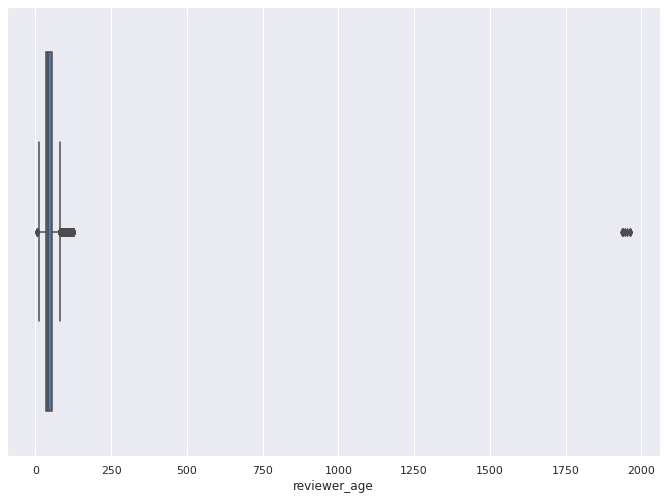

In [13]:
sns.boxplot(x=data_selected_features.reviewer_age)

<AxesSubplot:xlabel='reviewer_age'>

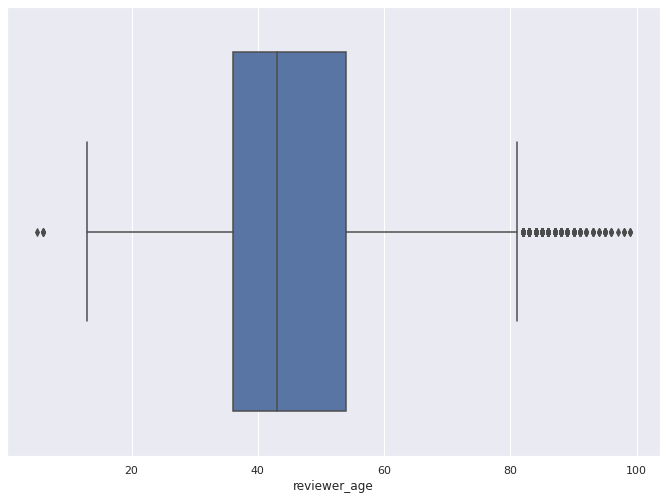

In [14]:
# remove meaningless data 
data_clean = data_selected_features.loc[data_selected_features.reviewer_age < 100]
sns.boxplot(x=data_clean.reviewer_age)


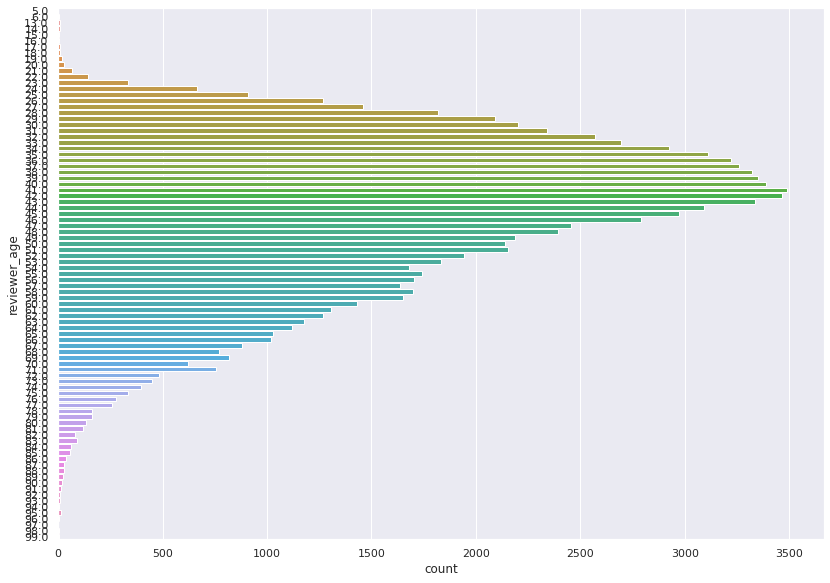

In [15]:
sns.countplot(y=data_clean.reviewer_age)
plt.tight_layout()

### Handling categorical features

In [16]:
cat_features = ["recommend_to_a_friend", "reviewer_gender", "reviewer_state"]

In [17]:
# find out if we have unexpected values
for feat in cat_features:
  print(feat, data_clean[feat].value_counts(dropna=False))

recommend_to_a_friend Yes    73484
No     27565
NaN       10
Name: recommend_to_a_friend, dtype: int64
reviewer_gender M      52143
F      48807
NaN      109
Name: reviewer_gender, dtype: int64
reviewer_state SP    38761
RJ    13993
MG    12990
PR     5227
RS     5095
BA     3750
SC     3450
ES     2401
PE     2364
GO     1942
DF     1910
CE     1696
PA     1198
MA      937
MT      785
RN      713
PB      681
MS      661
AL      578
PI      562
SE      430
TO      304
RO      263
AM      154
AP       96
AC       67
RR       51
Name: reviewer_state, dtype: int64


About dropping Nan and None values:

I'm dropping the None values here since we only have 109 occurrances of Nan in gender and more 10 in recommendation to a friend. So, I'm cleaning this data and it shouldn't affect our predictions. 

After this, I'm straight to cutting our data into train and test datasets in order to avoid data leakage with a minor pre-processing, wich is, encoding our data from the categorical features into encoded ones. 

Notice that we won't have data leakage here, since all possible samples data is already here. We won't have a third gender, another state or anoter possible answer to recommendation to a friend, so, this doesn't imply into a data leakage situation.

In [18]:
data_dropped = data_clean.dropna()

In [19]:
recommendation_mapping = {"Yes": 1, "No": 0}
gender_mapping = {"M": 1, "F": 0}
region_mapping = {
    "SP": 0,
    "RJ": 0,
    "MG": 0,
    "ES": 0,
    "RS": 1,
    "SC": 1,
    "PR": 1,
    "BA": 2,
    "SE": 2,
    "AL": 2,
    "PE": 2,
    "RN": 2,
    "PB": 2,
    "CE": 2,
    "PI": 2,
    "MA": 2,
    "GO": 3,
    "MS": 3,
    "MT": 3,
    "DF": 3,
    "TO": 3,
    "RO": 4,
    "AM": 4,
    "AP": 4,
    "AC": 4,
    "RR": 4 
}
mapping_index = 0
state_mapping = {}
for state in region_mapping.keys():
  state_mapping[state] = mapping_index
  mapping_index += 1

In [20]:
# df['A'] = df['A'].map(mapping)
data_dropped["recommend_map"] = data_dropped["recommend_to_a_friend"].map(recommendation_mapping)
data_dropped["gender_map"] = data_dropped["reviewer_gender"].map(gender_mapping)
data_dropped["region_map"] = data_dropped["reviewer_state"].map(region_mapping)
data_dropped["state_map"] = data_dropped["reviewer_state"].map(state_mapping)

<ipython-input-20-1c7de4af5391>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dropped["recommend_map"] = data_dropped["recommend_to_a_friend"].map(recommendation_mapping)
<ipython-input-20-1c7de4af5391>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dropped["gender_map"] = data_dropped["reviewer_gender"].map(gender_mapping)
<ipython-input-20-1c7de4af5391>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [21]:
data_dropped.head()

,recommend_to_a_friend,reviewer_birth_year,reviewer_gender,reviewer_state,overall_rating,reviewer_age,recommend_map,gender_map,region_map,state_map
0,Yes,1978.0,F,ES,5,45.0,1,0,0.0,3.0
1,Yes,1986.0,F,SP,5,37.0,1,0,0.0,0.0
2,Yes,1978.0,M,ES,3,45.0,1,1,0.0,3.0
3,No,1969.0,F,RJ,1,54.0,0,0,0.0,1.0
4,Yes,1965.0,M,PE,4,58.0,1,1,2.0,10.0


### Splitting

In [22]:
from sklearn.model_selection import train_test_split
data_new_drop = data_dropped.dropna()
y = data_new_drop.pop("overall_rating")
X_train, X_test, y_train, y_test = train_test_split(data_new_drop, y, test_size=0.2, random_state=816)

## Before building ML itself...

Lets explore what the train data can tell us about correlation between features.

In [23]:
from scipy.stats import pointbiserialr
mapped_features = ["recommend_map", 	"gender_map", 	"region_map", 	"state_map"]
for feat in X_train.loc[:, mapped_features].columns:
  r, p = pointbiserialr(X_train.loc[:, feat], y_train)
  print(f"For the feature {feat}, the point-biserial results are: \n")
  print(f"Correlation coefficient: {r}")
  print(f"P-value: {p}")


For the feature recommend_map, the point-biserial results are: 

Correlation coefficient: 0.8371576249558503
P-value: 0.0
For the feature gender_map, the point-biserial results are: 

Correlation coefficient: -0.019894280112123422
P-value: 1.906908955344115e-08
For the feature region_map, the point-biserial results are: 

Correlation coefficient: -0.0007937022478423641
P-value: 0.8225993425122358
For the feature state_map, the point-biserial results are: 

Correlation coefficient: -0.001330582444347683
P-value: 0.7070212175443014


This indicates what was expected for the recommend to a friend feature. If you are more likely to recommend something, the grade given is more likely to be higher and vice-versa. For the other features, since the P-value is high and the coefficient is low, we should not expect much correlation. 

In [24]:
corr_coef = np.corrcoef(X_train["reviewer_age"], y_train)[0, 1]

# print the correlation coefficient
print(corr_coef)

-0.001820942420243803


Here we also don't have a good correlation between age and score given.

### Conclusion about this minor exploration here:

A linear regression solution is less likely to return a good result here since we have just a single coefficient having a good contribution to correlation. 


# ML itself

- We will propose a linear regression, a simple one, and some regularized ones in order to verify if our hypothesis so far are valid.
- After this, we can approach the problem with other strategies such as:
  - A classification problem with the features we have
  - A clusterization problem with the features we have
  - Repeat both solutions with different feature reduction strategies (PCA, T-Sne)

My gut says that we shall have ok results, than go back and craft some more features from the commentaries and products, categories and so on.

## Regression

In [25]:
# convert data to DMatrix format
features_to_be_used = ["recommend_map", 	"gender_map", 	"region_map", 	"state_map", "reviewer_age"]
regression_data = X_train.loc[:, features_to_be_used]
dtrain = xgb.DMatrix(regression_data, label=y_train)

# Filtering data for inferences
inference_data = X_test.loc[:, features_to_be_used]

# Linear Regression with XGBoost
lr_params = {'objective': 'reg:linear'}
lr_model = xgb.train(lr_params, dtrain)
lr_pred = lr_model.predict(xgb.DMatrix(inference_data))

# Ridge Regression with XGBoost
ridge_params = {'objective': 'reg:linear', 'alpha': 1}
ridge_model = xgb.train(ridge_params, dtrain)
ridge_pred = ridge_model.predict(xgb.DMatrix(inference_data))

# Lasso Regression with XGBoost
lasso_params = {'objective': 'reg:linear', 'alpha': 0.1}
lasso_model = xgb.train(lasso_params, dtrain)
lasso_pred = lasso_model.predict(xgb.DMatrix(inference_data))

[13:28:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [26]:
# Printing the coefficients
def evaluate_model(model, y_pred, y_test):
    # Evaluation Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Coefficients
    if type(model) == LinearRegression or type(model) == Ridge or type(model) == Lasso:
        coef = model.coef_
        print("Coefficients:", coef)
    else:
        coef = model.get_score(importance_type='weight')
        print("Feature Importance Scores:", coef)
    
    # Print Results
    print("Evaluation Metrics:")
    print("MSE: {:.4f}, MAE: {:.4f}, R-squared: {:.4f}".format(mse, mae, r2))

In [27]:
print("Evaluating linear regression: \n")
evaluate_model(lr_model, lr_pred, y_test)
print("\n Evaluating ridge regression: \n")
evaluate_model(ridge_model, ridge_pred, y_test)
print("\n Evaluating lasso regression: \n")
evaluate_model(lasso_model, lasso_pred, y_test)

Evaluating linear regression: 

Feature Importance Scores: {'recommend_map': 10.0, 'gender_map': 47.0, 'region_map': 39.0, 'state_map': 168.0, 'reviewer_age': 241.0}
Evaluation Metrics:
MSE: 0.7310, MAE: 0.6728, R-squared: 0.6882

 Evaluating ridge regression: 

Feature Importance Scores: {'recommend_map': 10.0, 'gender_map': 39.0, 'region_map': 23.0, 'state_map': 140.0, 'reviewer_age': 213.0}
Evaluation Metrics:
MSE: 0.7318, MAE: 0.6733, R-squared: 0.6878

 Evaluating lasso regression: 

Feature Importance Scores: {'recommend_map': 10.0, 'gender_map': 44.0, 'region_map': 35.0, 'state_map': 156.0, 'reviewer_age': 262.0}
Evaluation Metrics:
MSE: 0.7312, MAE: 0.6729, R-squared: 0.6881


### Results

As you may remember from previous cells:

```
For the feature recommend_map, the point-biserial results are: 
Correlation coefficient: 0.8371576249558503
P-value: 0.0
```

And for all the regressions, we have for `recommended_map` the same coefficient, and for all the other features, quite similar coefficients as well. This was expected, since we knew that the only really meaningful variable here was the recommendation for a friend or not. 

Also, since we are trying different regulatizations and yet the outcomes are quite similar between MAE, MSE and R-squared, we can presume that the fitting proccess is not getting stuck or missing regulatization, but, we shall be pointing into a wrong direction with our strategy.

## Classification approach

Quick note, couldn't apply SVM here cause it took too long. I'll do it with feature reduction

In [28]:
# Create a list of classifiers to compare
classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=816)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Logistic Regression', LogisticRegression(random_state=816))
]

# Iterate over classifiers to compare
for clf_name, clf in classifiers:
  # Create a pipeline with StandardScaler and the classifier
  pipe = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
  
  # Fit the pipeline to the training data
  pipe.fit(regression_data, y_train)
  
  # Make predictions on the test data
  y_pred = pipe.predict(inference_data)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average="weighted")

  # Print the classification report
  print(clf_name)
  print("MSE:", mse)
  print("MAE:", mae)
  print("F1 score", f1)
  print(classification_report(y_test, y_pred))

Random Forest
MSE: 1.1105819840593514
MAE: 0.6432903904957642
F1 score 0.4575650220372178
              precision    recall  f1-score   support

           1       0.74      0.94      0.83      4148
           2       0.23      0.02      0.04      1325
           3       0.16      0.01      0.02      2483
           4       0.36      0.18      0.24      4868
           5       0.49      0.82      0.62      7125

    accuracy                           0.54     19949
   macro avg       0.40      0.40      0.35     19949
weighted avg       0.45      0.54      0.46     19949

K-Nearest Neighbors
MSE: 1.1619630056644443
MAE: 0.7035941651210587
F1 score 0.45689063424704635
              precision    recall  f1-score   support

           1       0.72      0.91      0.80      4148
           2       0.17      0.05      0.08      1325
           3       0.17      0.13      0.15      2483
           4       0.35      0.40      0.37      4868
           5       0.50      0.49      0.49      7125

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As it can be noticed, there's a huge difference for classificating samples for score 1 and for other scores. It's kind of clear when people try to evaluate, there's a clear distribution that is something more likely to be voted on minimum or maximum grade and less people vote for other grades. This leads us to an imbalanced dataset for training.

### 1st try - Use weighted classes

In [29]:
# Create a list of classifiers to compare
classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=816, class_weight='balanced')),
    ('Logistic Regression', LogisticRegression(random_state=816, class_weight='balanced'))
]

# Iterate over classifiers to compare
for clf_name, clf in classifiers:
  # Create a pipeline with StandardScaler and the classifier
  pipe = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
  
  # Fit the pipeline to the training data
  pipe.fit(regression_data, y_train)
  
  # Make predictions on the test data
  y_pred = pipe.predict(inference_data)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average="weighted")

  # Print the classification report
  print(clf_name)
  print("MSE:", mse)
  print("MAE:", mae)
  print("F1 score", f1)
  print(classification_report(y_test, y_pred))

Random Forest
MSE: 1.1729911273748057
MAE: 0.729760890270189
F1 score 0.4563449591153436
              precision    recall  f1-score   support

           1       0.75      0.75      0.75      4148
           2       0.21      0.21      0.21      1325
           3       0.17      0.19      0.18      2483
           4       0.35      0.41      0.38      4868
           5       0.53      0.44      0.48      7125

    accuracy                           0.45     19949
   macro avg       0.40      0.40      0.40     19949
weighted avg       0.46      0.45      0.46     19949

Logistic Regression
MSE: 0.9960399017494611
MAE: 0.6154694470900797
F1 score 0.4747415568641769
              precision    recall  f1-score   support

           1       0.74      0.95      0.83      4148
           2       0.23      0.02      0.04      1325
           3       0.00      0.00      0.00      2483
           4       0.37      0.48      0.42      4868
           5       0.52      0.59      0.55      7125



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Not this worth

### 2nd try - Apply ensamble methods to the methods

PS: Couldn't do it due an internal error from sklearn due deprecation of methods, also I didn't thought it would bring as much as value as what we're about to do

## Feature reduction and Classification

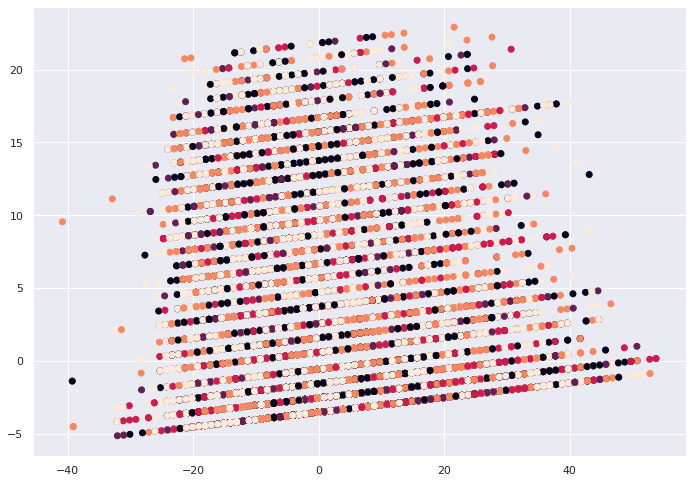

In [30]:
# Apply PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(regression_data)

# Plot results

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)
plt.show()

ok, at this point we know for sure that features are sh*t but I'm gonna be mean an try a 3D plot

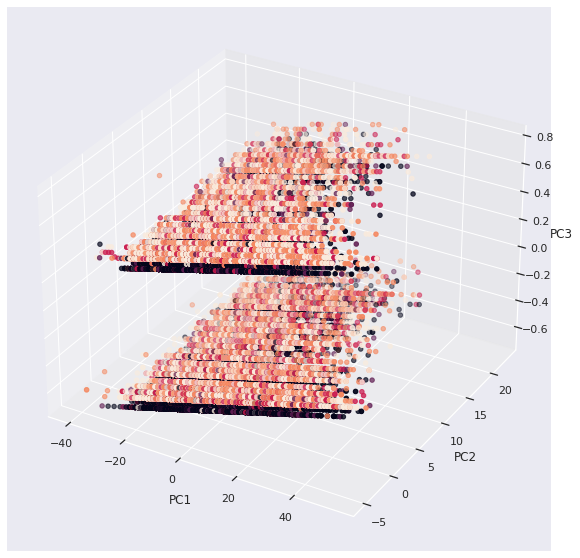

In [31]:
# Apply PCA with 3 components
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(regression_data)

# Plot results
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c=y_train)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

Well, now we know some stuff:

- PC3 is clearly the referral variable
- PC1 and 2 are combining the age of people in order to make the aligned dots in a combined direction
- Data is not that thrash, but is missing some data. 



# Reworking stuff and making good code (I guess)

## Refactor and automate code


### Pre-processing pipeline


In [32]:
data.reviewer_state.unique()

array(['ES', 'SP', 'RJ', 'PE', 'RN', 'MG', 'PR', 'MA', 'CE', 'PB', 'BA',
       'RS', 'AM', 'PI', 'DF', 'SC', 'PA', nan, 'GO', 'AL', 'MS', 'SE',
       'MT', 'RO', 'TO', 'RR', 'AP', 'AC'], dtype=object)

In [33]:
def map_cat_features(data):
  recommendation_mapping = {"Yes": 1, "No": 0}
  gender_mapping = {"M": 1, "F": 0}
  region_mapping = {
      "SP": 0,
      "RJ": 0,
      "MG": 0,
      "ES": 0,
      "RS": 1,
      "SC": 1,
      "PR": 1,
      "BA": 2,
      "SE": 2,
      "AL": 2,
      "PE": 2,
      "RN": 2,
      "PB": 2,
      "CE": 2,
      "PI": 2,
      "MA": 2,
      "GO": 3,
      "MS": 3,
      "MT": 3,
      "DF": 3,
      "TO": 3,
      "RO": 4,
      "PA": 4,
      "AM": 4,
      "AP": 4,
      "AC": 4,
      "RR": 4 
  }
  mapping_index = 0
  state_mapping = {}
  for state in region_mapping.keys():
    state_mapping[state] = mapping_index
    mapping_index += 1
  data["recommend_map"] = data["recommend_to_a_friend"].map(recommendation_mapping)
  data["gender_map"] = data["reviewer_gender"].map(gender_mapping)
  data["region_map"] = data["reviewer_state"].map(region_mapping)
  data["state_map"] = data["reviewer_state"].map(state_mapping)
  return data

In [34]:
def preprocess_data(data):
  # Selecting more data than the previous attempt
  selected_features = ["recommend_to_a_friend", "reviewer_birth_year", "reviewer_gender", "reviewer_state", "overall_rating", "product_id", "reviewer_id", "site_category_lv1", "site_category_lv2", "product_brand"]
  data_selected_features = data.loc[:,selected_features].fillna(method='ffill')
  # Some treatment on str variables
  str_cols_to_lower = ["site_category_lv1", "site_category_lv2", "product_brand"]
  data_selected_features[str_cols_to_lower] = data_selected_features[str_cols_to_lower].apply(lambda x: x.str.lower().fillna(method='ffill'))
  data_selected_features['reviewer_age'] = 2023 - data_selected_features.reviewer_birth_year
  data_clean = data_selected_features.loc[data_selected_features.reviewer_age < 100]
  mapped_data = map_cat_features(data_clean)
  prep_data = mapped_data.drop(["recommend_to_a_friend","reviewer_gender", "reviewer_state", "reviewer_birth_year"], axis=1)
  return prep_data

In [35]:
prep_data = preprocess_data(data)
y = prep_data["overall_rating"]
X = prep_data.drop("overall_rating", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=816)

<ipython-input-33-59b7596aad62>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["recommend_map"] = data["recommend_to_a_friend"].map(recommendation_mapping)
<ipython-input-33-59b7596aad62>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["gender_map"] = data["reviewer_gender"].map(gender_mapping)
<ipython-input-33-59b7596aad62>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

### Intermediate processing

Avoiding data leakage, but using frequency encoding

In [36]:
def frequency_encoding(data, features):
  mapping_dict = {}
  for feat in features:
    freq_dict = data[feat].value_counts().to_dict()
    data[feat] = data[feat].map(freq_dict)
    data[feat].fillna(data[feat].mean(), inplace=True)
    mapping_dict[feat] = freq_dict  
  return data, mapping_dict

In [37]:
def test_frequency_encoding(data, mapping_dict):
  for feat, freq_dict in mapping_dict.items():
    freq_dict = data[feat].value_counts().to_dict()
    data[feat] = data[feat].map(freq_dict)
    data[feat].fillna(data[feat].mean(), inplace=True)
  
  return data

## ML Pipeline

### Regression

In [38]:
def run_regression_pipelines(X_train, X_test, y_train, y_test):
  # convert data to DMatrix format
  fe_features = ["product_id", "reviewer_id", "site_category_lv1", "site_category_lv2", "product_brand"]
  X_train_fe, mapping_dict = frequency_encoding(X_train, features=fe_features)
  dtrain = xgb.DMatrix(X_train_fe, label=y_train)

  # Filtering data for inferences
  X_test_fe = test_frequency_encoding(X_test, mapping_dict)

  # Lasso Regression with XGBoost
  lasso_params = {'objective': 'reg:linear', 'alpha': 0.1}
  lasso_model = xgb.train(lasso_params, dtrain)
  lasso_pred = lasso_model.predict(xgb.DMatrix(X_test_fe))

  return lasso_model, lasso_pred

In [39]:
model, y_pred = run_regression_pipelines(X_train, X_test, y_train, y_test)

[13:29:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
# Printing the coefficients
def evaluate_model(model, y_pred, y_test):
  # Evaluation Metrics
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  # Coefficients

  coef = model.get_score(importance_type='weight')
  print("Feature Importance Scores:", coef)
  
  # Print Results
  print("Evaluation Metrics:")
  print("MSE: {:.4f}, MAE: {:.4f}, R-squared: {:.4f}".format(mse, mae, r2))

In [41]:
evaluate_model(model, y_pred, y_test)

Feature Importance Scores: {'product_id': 101.0, 'reviewer_id': 54.0, 'site_category_lv1': 79.0, 'site_category_lv2': 67.0, 'product_brand': 62.0, 'reviewer_age': 102.0, 'recommend_map': 10.0, 'gender_map': 16.0, 'region_map': 9.0, 'state_map': 30.0}
Evaluation Metrics:
MSE: 0.7118, MAE: 0.6617, R-squared: 0.6971


Previous results were:
MSE: 0.7312, MAE: 0.6729, R-squared: 0.6881

It can be noticed that R-squared is lower but the others are higher. We will plot the comparison in order to understand what is going on.

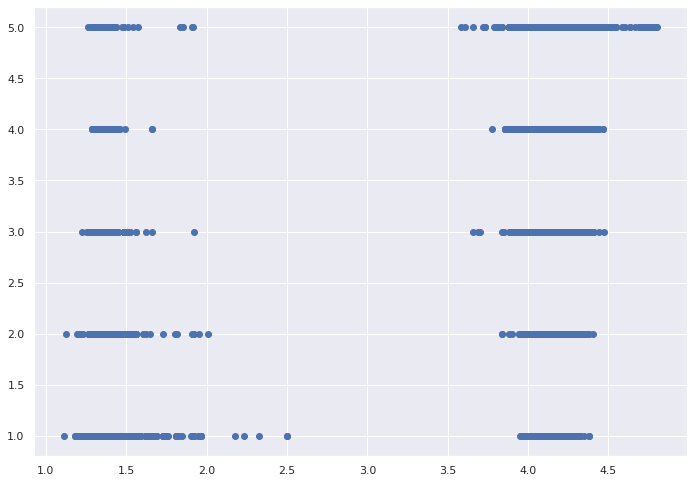

In [42]:
plt.scatter(x=y_pred, y=y_test)

In [43]:
# Last try: round the results

y_pred_round = np.round(y_pred).astype(int)
evaluate_model(model, y_pred_round, y_test)

Feature Importance Scores: {'product_id': 101.0, 'reviewer_id': 54.0, 'site_category_lv1': 79.0, 'site_category_lv2': 67.0, 'product_brand': 62.0, 'reviewer_age': 102.0, 'recommend_map': 10.0, 'gender_map': 16.0, 'region_map': 9.0, 'state_map': 30.0}
Evaluation Metrics:
MSE: 0.7951, MAE: 0.6208, R-squared: 0.6617


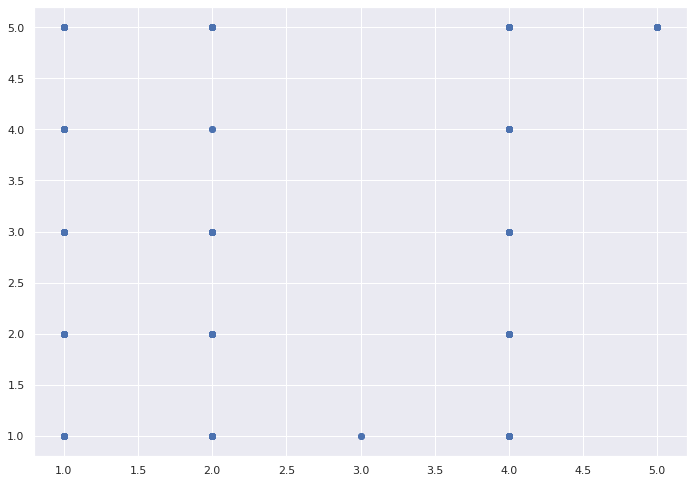

In [44]:
plt.scatter(x=y_pred_round, y=y_test)

Regression results:

Nah, nothing seems good. The problem is not well suited for a regression problem and lasso failed brutally

### Classification


In [45]:
def run_cls(X_train, X_test, y_train, y_test):
  fe_features = ["product_id", "reviewer_id", "site_category_lv1", "site_category_lv2", "product_brand"]
  X_train_fe, mapping_dict = frequency_encoding(X_train, features=fe_features)
  X_test_fe = test_frequency_encoding(X_test, mapping_dict)
  # Create a list of classifiers to compare
  classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=816, class_weight='balanced')),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Logistic Regression', LogisticRegression(random_state=816, class_weight='balanced'))
  ]

  # Iterate over classifiers to compare
  for clf_name, clf in classifiers:
    # Create a pipeline with StandardScaler and the classifier
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
    
    # Fit the pipeline to the training data
    pipe.fit(X_train_fe, y_train)
    
    # Make predictions on the test data
    y_pred = pipe.predict(X_test_fe)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Print the classification report
    print(clf_name)
    print("MSE:", mse)
    print("MAE:", mae)
    print(classification_report(y_test, y_pred))

In [46]:
run_cls(X_train, X_test, y_train, y_test)

Random Forest
MSE: 1.0724576071040575
MAE: 0.6301544565679468
              precision    recall  f1-score   support

           1       0.75      0.97      0.85      4408
           2       0.12      0.00      0.00      1295
           3       0.16      0.02      0.04      2527
           4       0.36      0.17      0.23      5228
           5       0.50      0.82      0.62      7713

    accuracy                           0.54     21171
   macro avg       0.38      0.40      0.35     21171
weighted avg       0.45      0.54      0.46     21171

K-Nearest Neighbors
MSE: 1.2058948561711775
MAE: 0.7287327003920457
              precision    recall  f1-score   support

           1       0.75      0.94      0.83      4408
           2       0.12      0.03      0.05      1295
           3       0.15      0.19      0.17      2527
           4       0.34      0.33      0.33      5228
           5       0.50      0.46      0.48      7713

    accuracy                           0.47     21171
 

### PCA + Classification

In [47]:
def run_pca(X_train, X_test):
  fe_features = ["product_id", "reviewer_id", "site_category_lv1", "site_category_lv2", "product_brand"]
  X_train_fe, mapping_dict = frequency_encoding(X_train, features=fe_features)
  X_test_fe = test_frequency_encoding(X_test, mapping_dict)
  # PCA
  pca_3 = PCA(n_components=3)
  X_train_pca = pca_3.fit_transform(X_train_fe)
  X_test_pca = pca_3.transform(X_test_fe)
  return X_train_pca, X_test_pca

In [48]:
def run_cls_pca(X_train, X_test, y_train, y_test):
  X_train_pca, X_test_pca = run_pca(X_train, X_test)
  # Create a list of classifiers to compare
  classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=816, class_weight='balanced')),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Logistic Regression', LogisticRegression(random_state=816, class_weight='balanced'))
  ]

  cls_results_dict = {}
  # Iterate over classifiers to compare
  for clf_name, clf in classifiers:
    # Create a pipeline with StandardScaler and the classifier
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
    
    # Fit the pipeline to the training data
    pipe.fit(X_train_pca, y_train)
    
    # Make predictions on the test data
    y_pred = pipe.predict(X_test_pca)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Print the classification report
    print(clf_name)
    print("MSE:", mse)
    print("MAE:", mae)
    print(classification_report(y_test, y_pred))
    cls_results_dict[clf_name] = y_pred

  return cls_results_dict

In [49]:
results = run_cls_pca(X_train, X_test, y_train, y_test)

Random Forest
MSE: 4.922818950451089
MAE: 1.6084738557460678
              precision    recall  f1-score   support

           1       0.21      0.12      0.15      4408
           2       0.00      0.00      0.00      1295
           3       0.09      0.01      0.02      2527
           4       0.26      0.09      0.13      5228
           5       0.36      0.77      0.49      7713

    accuracy                           0.33     21171
   macro avg       0.18      0.20      0.16     21171
weighted avg       0.25      0.33      0.24     21171

K-Nearest Neighbors
MSE: 4.966227386519296
MAE: 1.7230173350337725
              precision    recall  f1-score   support

           1       0.23      0.35      0.28      4408
           2       0.07      0.08      0.07      1295
           3       0.12      0.15      0.13      2527
           4       0.26      0.19      0.22      5228
           5       0.38      0.29      0.33      7713

    accuracy                           0.25     21171
   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Deep learning

In [50]:
def y_encoder(y):
  # create OneHotEncoder object
  encoder = OneHotEncoder()

  # fit and transform y_train
  y_encoded = encoder.fit_transform(y.reshape(-1, 1)).toarray()
  return y_encoded, encoder

In [51]:
X_train.shape

(84680, 10)

In [52]:


# define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
fe_features = ["product_id", "reviewer_id", "site_category_lv1", "site_category_lv2", "product_brand"]
X_train_fe, mapping_dict = frequency_encoding(X_train, features=fe_features)
X_test_fe = test_frequency_encoding(X_test, mapping_dict)
y_train_encoded, encoder = y_encoder(y_train.values)
model.fit(X_train_fe, y_train_encoded, epochs=50, batch_size=int(X_train_fe.shape[0]/50))


Epoch 1/50
51/51 [==============================] - 2s 6ms/step - loss: 150.4110 - accuracy: 0.3070
Epoch 2/50
51/51 [==============================] - 0s 7ms/step - loss: 2.7525 - accuracy: 0.1736
Epoch 3/50
51/51 [==============================] - 0s 7ms/step - loss: 1.7342 - accuracy: 0.1769
Epoch 4/50
51/51 [==============================] - 0s 6ms/step - loss: 1.6460 - accuracy: 0.3207
Epoch 5/50
51/51 [==============================] - 0s 7ms/step - loss: 1.5995 - accuracy: 0.3606
Epoch 6/50
51/51 [==============================] - 1s 10ms/step - loss: 1.5714 - accuracy: 0.3608
Epoch 7/50
51/51 [==============================] - 1s 11ms/step - loss: 1.5525 - accuracy: 0.3609
Epoch 8/50
51/51 [==============================] - 1s 11ms/step - loss: 1.5404 - accuracy: 0.3609
Epoch 9/50
51/51 [==============================] - 1s 10ms/step - loss: 1.5297 - accuracy: 0.3611
Epoch 10/50
51/51 [==============================] - 1s 16ms/step - loss: 1.5213 - accuracy: 0.3612
Epoch 11/50


In [53]:
y_pred = model.predict(X_test_fe)

662/662 [==============================] - 1s 2ms/step


In [54]:
y_pred = np.round(y_pred)
y_pred[0]

array([0., 0., 0., 0., 0.], dtype=float32)

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).toarray()
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 4.723442444853809e-05
Precision: 0.09107977894289358
Recall: 4.7234424448538086e-05
F1 Score: 9.441988227849533e-05


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# New strategy

I'll try to make a 2 step pipeline here, creating two models. One gets all the data with the recommendation as Yes and tries to predict the grades. The other, tries to guess when the recommendation is No. In order to know if this will work, first we discover how is the grade distribution by this feature and figure it out how to split the votes

<AxesSubplot:xlabel='overall_rating', ylabel='count'>

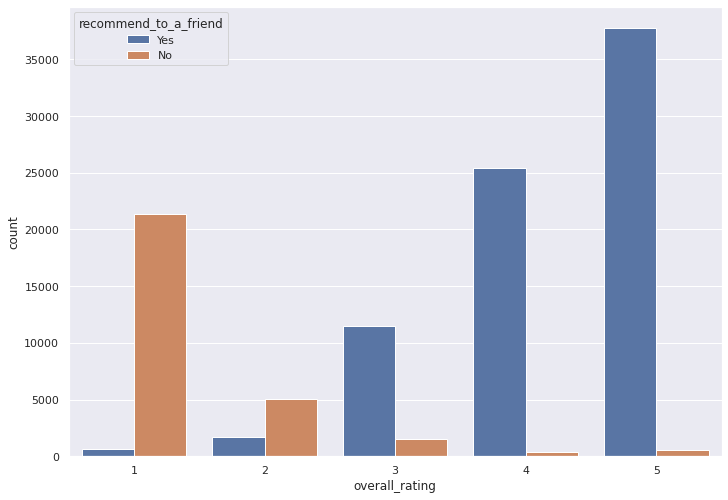

In [57]:
sns.countplot(data=data, x="overall_rating", hue="recommend_to_a_friend")

Since this data is clearly unbalanced, I'll try to do this:

- If the recommendation is no, I'll make a model to guess if the rating is 1 or 2
- Else, try to guess if the rate is 3, 4 or 5

In [58]:
prep_data = preprocess_data(data)
prep_data.head()

<ipython-input-33-59b7596aad62>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["recommend_map"] = data["recommend_to_a_friend"].map(recommendation_mapping)
<ipython-input-33-59b7596aad62>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["gender_map"] = data["reviewer_gender"].map(gender_mapping)
<ipython-input-33-59b7596aad62>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,overall_rating,product_id,reviewer_id,site_category_lv1,site_category_lv2,product_brand,reviewer_age,recommend_map,gender_map,region_map,state_map
0,5,111586438,c951f3a4511b554a1f34330903c320f34cfccbdf8de357...,beleza e perfumaria,depilação,philips,45.0,1,0,0,3
1,5,19399940,21da6d1c6d022a5c67da402d3082c7c438660f4252b7c3...,beleza e perfumaria,tratamento de pele,philips,37.0,1,0,0,0
2,3,22747780,eaf2f059cbb702e377bf95ac998aa4365f851937a3b419...,games,xbox 360,philips,45.0,1,1,0,3
3,1,22857850,e5bb0709d14bc4a00aeaeb1f111616e69f57239dff7da6...,"cama, mesa e banho",edredom,philips,54.0,0,0,0,1
4,4,132207708,420a3ab1adf3c6010d491c8def04e19b1439ed01df7038...,celulares e smartphones,smartphone,motorola,58.0,1,1,2,10


## Lower scores model

In [60]:
lwr_data = prep_data.loc[prep_data.recommend_map == 0]

In [61]:
y = lwr_data["overall_rating"]
X = lwr_data.drop("overall_rating", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=816)

### Regression

In [62]:
model, y_pred = run_regression_pipelines(X_train, X_test, y_train, y_test)

[13:40:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [63]:
evaluate_model(model, y_pred, y_test)

Feature Importance Scores: {'product_id': 73.0, 'reviewer_id': 30.0, 'site_category_lv1': 54.0, 'site_category_lv2': 73.0, 'product_brand': 71.0, 'reviewer_age': 116.0, 'gender_map': 8.0, 'region_map': 13.0, 'state_map': 57.0}
Evaluation Metrics:
MSE: 0.6317, MAE: 0.5682, R-squared: -0.0240


Previous results with regression were:

`MSE: 0.7118, MAE: 0.6617, R-squared: 0.6971`

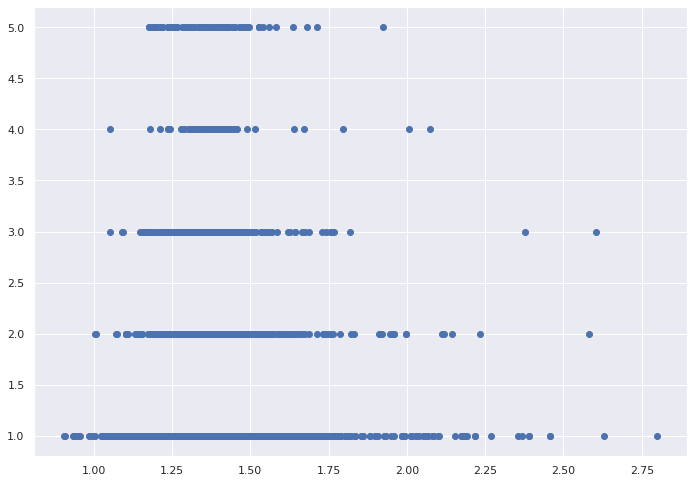

In [64]:
plt.scatter(x=y_pred, y=y_test)

Again rounding

In [65]:
y_pred_round = np.round(y_pred).astype(int)
evaluate_model(model, y_pred_round, y_test)

Feature Importance Scores: {'product_id': 73.0, 'reviewer_id': 30.0, 'site_category_lv1': 54.0, 'site_category_lv2': 73.0, 'product_brand': 71.0, 'reviewer_age': 116.0, 'gender_map': 8.0, 'region_map': 13.0, 'state_map': 57.0}
Evaluation Metrics:
MSE: 0.7739, MAE: 0.4190, R-squared: -0.2545


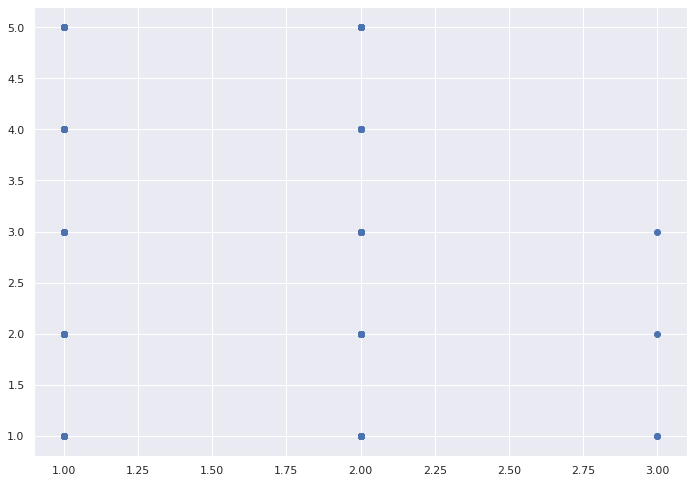

In [66]:
plt.scatter(x=y_pred_round, y=y_test)

### Classification

In [67]:
run_cls(X_train, X_test, y_train, y_test)

Random Forest
MSE: 0.7671398891966759
MAE: 0.3862534626038781
              precision    recall  f1-score   support

           1       0.74      1.00      0.85      4271
           2       1.00      0.00      0.00      1051
           3       0.00      0.00      0.00       284
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00       101

    accuracy                           0.74      5776
   macro avg       0.35      0.20      0.17      5776
weighted avg       0.73      0.74      0.63      5776



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Nearest Neighbors
MSE: 0.7685249307479224
MAE: 0.4021814404432133
              precision    recall  f1-score   support

           1       0.74      0.96      0.84      4271
           2       0.22      0.05      0.08      1051
           3       0.00      0.00      0.00       284
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00       101

    accuracy                           0.72      5776
   macro avg       0.19      0.20      0.18      5776
weighted avg       0.59      0.72      0.63      5776



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression
MSE: 5.482686980609419
MAE: 1.8424515235457064
              precision    recall  f1-score   support

           1       0.76      0.41      0.53      4271
           2       0.00      0.00      0.00      1051
           3       0.00      0.00      0.00       284
           4       0.01      0.45      0.02        69
           5       0.02      0.13      0.03       101

    accuracy                           0.31      5776
   macro avg       0.16      0.20      0.12      5776
weighted avg       0.56      0.31      0.39      5776



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It seems we're getting somewhere. Now, I'm running just the random forest, since it had the best results so far. Delivering the best accuracy, precision and recall. Running just this model, we'll be able to figure it out what is happening under the hood.

### Random Forest

In [78]:
fe_features = ["product_id", "reviewer_id", "site_category_lv1", "site_category_lv2", "product_brand"]
X_train_fe, mapping_dict = frequency_encoding(X_train, features=fe_features)
X_test_fe = test_frequency_encoding(X_test, mapping_dict)
# Create a list of classifiers to compare
rf = RandomForestClassifier(n_estimators=400, random_state=816, class_weight='balanced')

# Create a pipeline with StandardScaler and the RandomForest
pipe = Pipeline([('scaler', StandardScaler()), ('clf', rf)])

# Fit the pipeline to the training data
pipe.fit(X_train_fe, y_train)

# Make predictions on the test data
y_pred = pipe.predict(X_test_fe)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the classification report
print(clf_name)
print("MSE:", mse)
print("MAE:", mae)
print(classification_report(y_test, y_pred))

Logistic Regression
MSE: 0.7657548476454293
MAE: 0.3859072022160665
              precision    recall  f1-score   support

           1       0.74      1.00      0.85      4271
           2       1.00      0.00      0.00      1051
           3       0.00      0.00      0.00       284
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00       101

    accuracy                           0.74      5776
   macro avg       0.35      0.20      0.17      5776
weighted avg       0.73      0.74      0.63      5776



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

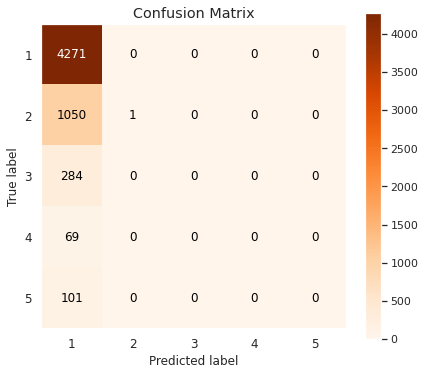

In [79]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                    title="Confusion Matrix",
                                    cmap="Oranges",
                                    ax=ax1)

Ok, our model is again facing another issue with imbalanced dataset. And our path chosen didn't helped indeed. So. I'm moving to my last move.

# SMOTE to classifiers

In [80]:
def run_cls_smote(X_train, X_test, y_train, y_test):
  fe_features = ["product_id", "reviewer_id", "site_category_lv1", "site_category_lv2", "product_brand"]
  X_train_fe, mapping_dict = frequency_encoding(X_train, features=fe_features)
  X_test_fe = test_frequency_encoding(X_test, mapping_dict)
  # Create SMOTE object
  smote = SMOTE()

  # Fit and apply SMOTE to the training data
  X_train_fe_smote, y_train_smote = smote.fit_resample(X_train_fe, y_train)
  # Create a list of classifiers to compare
  classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=816, class_weight='balanced')),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Logistic Regression', LogisticRegression(random_state=816, class_weight='balanced'))
  ]

  # Iterate over classifiers to compare
  for clf_name, clf in classifiers:
    # Create a pipeline with StandardScaler and the classifier
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
    
    # Fit the pipeline to the training data
    pipe.fit(X_train_fe_smote, y_train_smote)
    
    # Make predictions on the test data
    y_pred = pipe.predict(X_test_fe)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Print the classification report
    print(clf_name)
    print("MSE:", mse)
    print("MAE:", mae)
    print(classification_report(y_test, y_pred))

In [82]:
y = prep_data["overall_rating"]
X = prep_data.drop("overall_rating", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=816)
run_cls_smote(X_train, X_test, y_train, y_test)

Random Forest
MSE: 1.1675405035189645
MAE: 0.7239147890982949
              precision    recall  f1-score   support

           1       0.75      0.80      0.78      4408
           2       0.20      0.15      0.17      1295
           3       0.15      0.18      0.16      2527
           4       0.36      0.35      0.36      5228
           5       0.51      0.49      0.50      7713

    accuracy                           0.46     21171
   macro avg       0.39      0.40      0.39     21171
weighted avg       0.46      0.46      0.46     21171

K-Nearest Neighbors
MSE: 1.3511407113504321
MAE: 0.835057389825705
              precision    recall  f1-score   support

           1       0.75      0.66      0.70      4408
           2       0.16      0.25      0.19      1295
           3       0.15      0.32      0.21      2527
           4       0.34      0.37      0.36      5228
           5       0.52      0.29      0.37      7713

    accuracy                           0.39     21171
  

# Conclusion

After SMOTE effort didn't showing any results, what I can infer here is that I was unable to engineer representative features to this case. Probably, applying some NLP techniques it would've been helped the models to understand better the data. 

I tried to let it written down for you what was my logical thinking alongside the proccess in order to let you know how I think about a ML problem.
